**THIS NOTEBOOK CONTAINS APPLICATION OF SARIMA MODEL FOR SELLER 5 FORM SELLS DATA AND SELLER 23 FORM INVOICE DATA BY FINDIG THE BEST MODEL BY TRAIN TEST APPROACH.**

**Below is importing the requisite libraries for the notebook.**

In [1]:
#Importing the prerequisite libraries that are to be used further.
import pandas as pd
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib.pyplot as plt

**Importing the sales and invoice data.**

In [247]:
sales=pd.read_csv("sales_receipt.csv")
invoice=pd.read_csv("inv_transdt_transamt_selrid.csv")

**Preparing the data by formating date.**

In [248]:
sales["TransactionDate"]=pd.to_datetime(pd.to_datetime(sales.TransactionDate).dt.date)
invoice["TransactionDate"]=pd.to_datetime(pd.to_datetime(invoice.TransactionDate).dt.date)

**Extracting needed variables from the dataframes.**

In [249]:
invoice.groupby("SellerId").Trans_amount.count()

SellerId
1         8
2       631
3        97
5      1790
6        32
9      2898
10    20803
11     4118
12     7946
13      654
14     2676
15     4575
16      967
17      556
18     1990
19        2
20     2316
21    25065
22     1035
23     4663
24       51
25     2439
26      321
27      454
28      232
Name: Trans_amount, dtype: int64

In [250]:
sales_fin=sales[["TransactionDate","SellerId", "Amount"]]
invoice_fin=invoice[["TransactionDate","SellerId", "Trans_amount"]]

<font color="red"> **SARIMA MODEL FOR SELLS DATA FOR SELLER 5 WHICH IS A SEASONAL DATA.**</font>

**Data extraction for seller 5 and preparing the time series.**

In [251]:
data=sales_fin[sales_fin["SellerId"]==5][["TransactionDate","Amount"]]
data=data.set_index("TransactionDate")
data=data.groupby(pd.Grouper(freq="M")).sum()
ts=data["Amount"]
ts=ts.apply(lambda x: int(x))

In [252]:
len(ts)

43

**Below plot shows that the data is seasonal.**

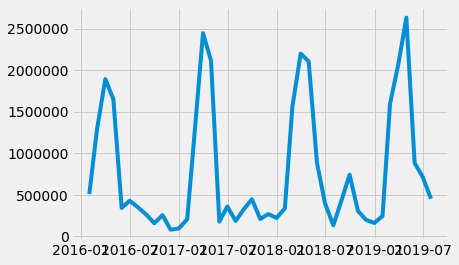

In [253]:
plt.plot(ts)

<font color="red"> **TRAIN TEST APPROACH TO FIND THE BEST SPLIT**</font>

**Below function is to connect the first index of predicted value with last index of the time series.**

In [254]:
def pred_fina(predicted, train):
    c=pd.Index(predicted.index)
    c=c.insert(0, pd.to_datetime(train.index[-1]))
    lis=list(predicted.values)
    lis.insert(0,train[-1])
    lis=pd.Series(lis,index=c)
    prediction_final=lis.apply(lambda x:int(x))
    return prediction_final

**Below code is all about spliting the time series at different reatios, fitting the model at train set, predicting on the test set, finding the aic for different ratios.**

In [255]:
from statsmodels.tsa.stattools import adfuller
def dft(ts):
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test_stats','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return(dfoutput)

In [256]:
dft(ts)

Test_stats                     -1.596981
p-value                         0.485110
#Lags Used                     10.000000
Number of Observations Used    32.000000
Critical Value (1%)            -3.653520
Critical Value (5%)            -2.957219
Critical Value (10%)           -2.617588
dtype: float64

**Output shows that data is not stationary so we need to apply differencing.**

**Below code contains training of SARIMA model at different ratio of data in train set and also calculates corresponding aic value for the model.**

In [257]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
#An empty list to store mean squared error.
rmse=[]
#An empty list to store aic.
aic=[]
# An empty list storing fraction of total data present in training set.
ratio=[]
for x in np.arange(0.6,0.95,0.005):
    #size of training set.
    train_size = int(len(ts)*x)
    #splitting the data.    
    train, test = ts[0:train_size], ts[train_size:len(ts)]
    train_diff=train-train.shift()
    train_diff=train_diff.dropna()
    if dft(train_diff)[0]<dft(train_diff)[4]:
        model = SARIMAX(train_diff, order=(1,0,1), seasonal_order=(1,0,1,2))
        model_fit = model.fit(disp=False)
        prediction_final= model_fit.predict(test.index[0], test.index[-1])
        predict=pred_fina(prediction_final, train)
        pred_fin=predict.cumsum()
        aic.append(model_fit.aic)
        rmse.append(np.sqrt(np.mean((-test+pred_fin)**2)))
        ratio.append(x)     

**Preparation a dataframe of ratio and aic value.**

In [258]:
ratio_aic=pd.DataFrame()
ratio_aic["ratio"]=ratio
ratio_aic["aic"]=aic

**Below code shows the variation of aic with ratio.**

In [259]:
ratio_aic

,ratio,aic
0,0.675,836.254908
1,0.680,836.254908
2,0.685,836.254908
3,0.690,836.254908
4,0.695,836.254908
5,0.700,864.813398
6,0.705,864.813398
7,0.710,864.813398
8,0.715,864.813398
9,0.720,864.813398


**Plotting the aic against ratio.**

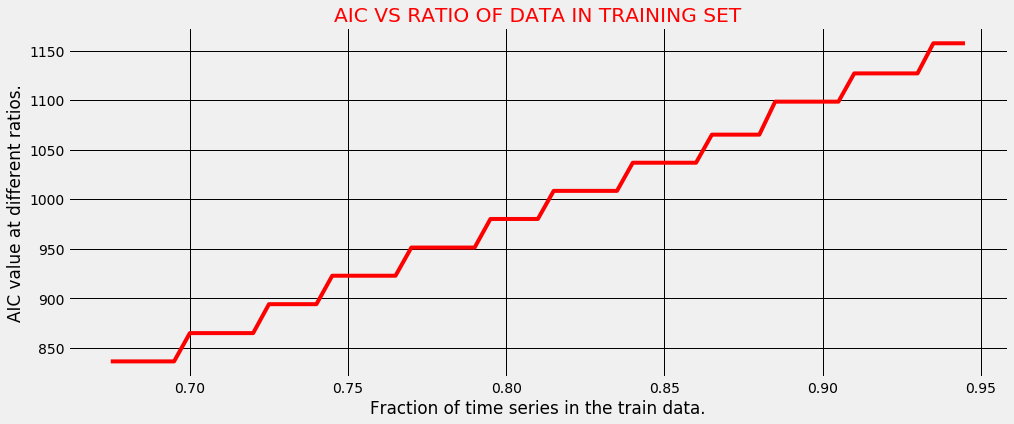

In [260]:
plt.figure(figsize=(15,6))
plt.plot(ratio_aic.ratio, ratio_aic.aic, color="red")
plt.xlabel("Fraction of time series in the train data.")
plt.ylabel("AIC value at different ratios.")
plt.title("AIC VS RATIO OF DATA IN TRAINING SET", color="red")
plt.grid(True, color="black")
plt.show()

**From above plot 0.675 is the best split to continue with for modeling.**

**Creating the train test data at the best ratio.**

In [261]:
train_size = int(len(ts)*0.675)   
train, test = ts[0:train_size], ts[train_size:len(ts)]
train_diff=train-train.shift()
train_diff=train_diff.dropna()

**Below are the steps to find the order of the model.**

In [262]:
from statsmodels.tsa.stattools import acf, pacf
# Requisite libraries for computing auto correlation function and partial auto correlation function. 
lag_acf = acf(train_diff, nlags=6)
lag_pacf = pacf(train_diff, nlags=8, method='ols')
#ols stands for ordinary least squared.

Text(0.5, 1.0, 'Autocorrelation Function')

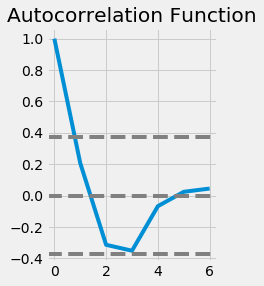

In [263]:
#This is the plotting of acf.
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

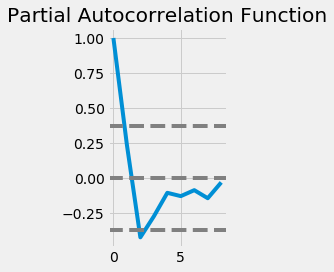

In [264]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [265]:
test.tail()

TransactionDate
2019-03-31    2071750
2019-04-30    2633150
2019-05-31     883200
2019-06-30     716999
2019-07-31     453750
Freq: M, Name: Amount, dtype: int64

**Below is code to run the SARIMA Model on the data.**

In [266]:
model = SARIMAX(train_diff, order=(2,1,1), seasonal_order=(1,1,1,1))
model_fit = model.fit(disp=False)
prediction_final= model_fit.predict("2018-06-30", "2019-7-31")
predict=pred_fina(prediction_final, train)
pred_fin=predict.cumsum()

In [267]:
model_fit.aic

792.3474301559091

In [268]:
model_fit.bic

799.896009384038

**This is the final prediction**

In [269]:
pred_fin

2018-05-31     885676
2018-06-30     506768
2018-07-31     820446
2018-08-31    1221911
2018-09-30    1276177
2018-10-31    1093848
2018-11-30     944522
2018-12-31     933451
2019-01-31     981624
2019-02-28     989954
2019-03-31     941300
2019-04-30     876562
2019-05-31     828201
2019-06-30     794077
2019-07-31     756318
Freq: M, dtype: int64

**Following plot shows the variation of forecasted value and the whole time series.**

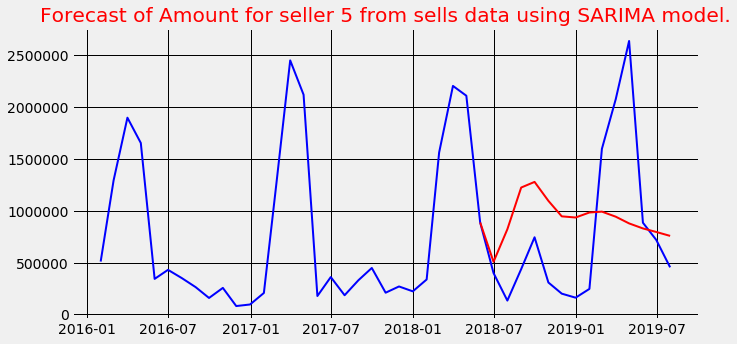

In [270]:
plt.figure(figsize=(10,5))
plt.plot(ts, color="blue", linewidth=2)
plt.plot(pred_fin, color="red", linewidth=2)
plt.title("Forecast of Amount for seller 5 from sells data using SARIMA model.", color="red")
plt.grid(True, color="black")
plt.show()

<font color="red"> **SARIMA MODEL FOR INVOICES DATA FOR SELLER ID 23.**</font>

**Train test approach**

**Data preparation stage**

In [271]:
data=invoice_fin[invoice_fin["SellerId"]==23][["TransactionDate","Trans_amount"]]
data=data.set_index("TransactionDate")
data=data.groupby(pd.Grouper(freq="M")).sum()
ts=data["Trans_amount"]
ts=ts.apply(lambda x: int(x))

In [272]:
len(ts)

37

**Testing the stationary of the data.**

In [273]:
dft(ts)

Test_stats                     -4.333429
p-value                         0.000389
#Lags Used                      0.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64

**The data is stationary and hence no need of any transformation and differencing.**

**Below is the connecter function to connect the first index of predicted series and last of the training series.**

In [274]:
def xyz(predicted, train):
    c=pd.Index(predicted.index)
    c=c.insert(0, pd.to_datetime(train.index[-1]))
    lis=list(predicted.values)
    lis.insert(0,train[-1])
    lis=pd.Series(lis,index=c)
    prediction_final=lis.apply(lambda x:int(x))
    return prediction_final

**Importing requisite libraries for finding the order of sarima model.**

In [275]:
from statsmodels.tsa.stattools import acf, pacf
# Requisite libraries for computing auto correlation function and partial auto correlation function. 
lag_acf = acf(ts, nlags=5)
lag_pacf = pacf(ts, nlags=8, method='ols')
#ols stands for ordinary least squared.

**ACF plot to know q value**

Text(0.5, 1.0, 'Autocorrelation Function')

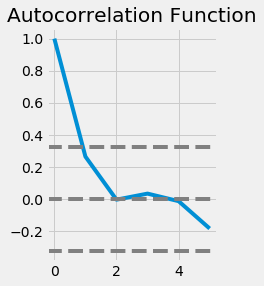

In [276]:
#This is the plotting of acf.
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

**PACF plot to get p value.**

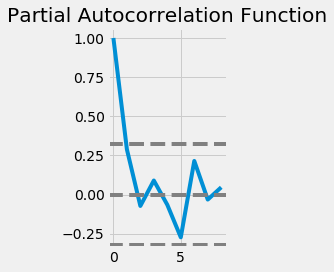

In [277]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

**Below code contains the trial of different SARIMA models at different fraction of data in the train set. It also contains the computation of aic values of models prepared at different ratios.**

In [278]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
#An empty list to store mean squared error.
rmse=[]
#An empty list to store aic.
aic=[]
# An empty list storing fraction of total data present in training set.
ratio=[]
for x in np.arange(0.6,0.95,0.005):
    #size of training set.
    train_size = int(len(ts)*x)
    #splitting the data.    
    train, test = ts[0:train_size], ts[train_size:len(ts)]
    train_diff=train-train.shift()
    train_diff=train_diff.dropna()
    if dft(train_diff)[0]<dft(train_diff)[4]:
        model = SARIMAX(train_diff, order=(2,1,0), seasonal_order=(1,0,0,2))
        model_fit = model.fit(disp=False)
        prediction_final= model_fit.predict(test.index[0], test.index[-1])
        predict=xyz(prediction_final, train)
        predict=predict.cumsum()
        aic.append(model_fit.aic)
        rmse.append(np.sqrt(np.mean((-test+pred_fin)**2)))
        ratio.append(x)     

**Below code is to create the dataframe of ratio and aic values to find the best model.**

In [279]:
aic_ratio=pd.DataFrame()
aic_ratio["ratio"]=ratio
aic_ratio["aic"]=aic

In [280]:
aic_ratio

,ratio,aic
0,0.650,762.174862
1,0.655,762.174862
2,0.660,762.174862
3,0.665,762.174862
4,0.670,762.174862
5,0.675,762.174862
6,0.840,1009.325379
7,0.845,1009.325379
8,0.850,1009.325379
9,0.855,1009.325379


**Plotting aic against ratio.**

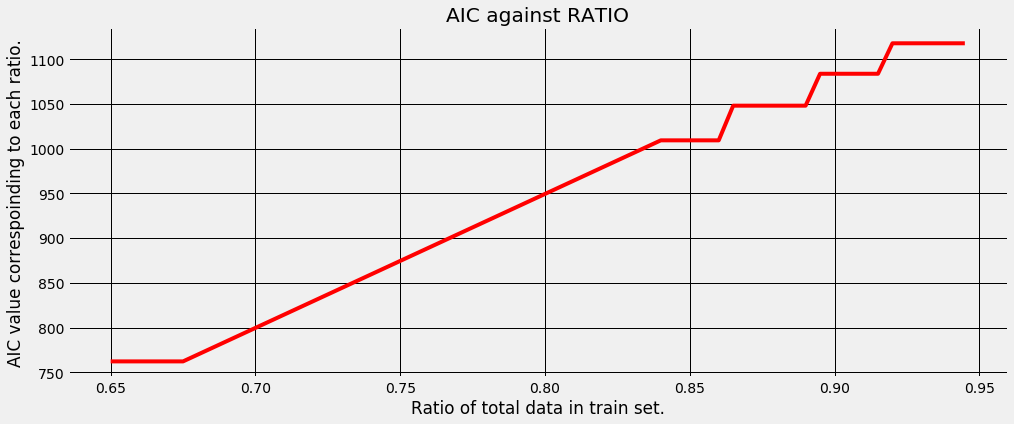

In [281]:
plt.figure(figsize=(15,6))
plt.plot(aic_ratio.ratio, aic_ratio.aic, color="red")
plt.xlabel("Ratio of total data in train set.")
plt.ylabel("AIC value correspoinding to each ratio.")
plt.title("AIC against RATIO")
plt.grid(True, color="black")
plt.show()

**From above code the best ratio value is 0.675.**

In [282]:
data=invoice_fin[invoice_fin["SellerId"]==23][["TransactionDate","Trans_amount"]]
data=data.set_index("TransactionDate")
data=data.groupby(pd.Grouper(freq="M")).sum()
ts=data["Trans_amount"]
ts=ts.apply(lambda x: int(x))
ts=ts[:-1]

In [283]:
len(ts)

36

**Preparing the data.**

In [284]:
train_size = int(len(ts)*0.675)    
train, test = ts[0:train_size], ts[train_size:len(ts)]

**Sample of time series.**

In [285]:
test.tail()

TransactionDate
2019-05-31    29867077
2019-06-30    15854985
2019-07-31    12353882
2019-08-31           0
2019-09-30           0
Freq: M, Name: Trans_amount, dtype: int64

**preparing the model with requisite order.**

In [286]:
model = SARIMAX(train_diff, order=(2,1,0), seasonal_order=(1,0,0,12))

**Fitting the model.**

In [287]:
model_fit = model.fit(disp=False)

In [288]:
model_fit.aic

1122.0428818501337

In [289]:
model_fit.bic

1127.9058254613326

In [290]:
train.tail()

TransactionDate
2018-05-31     9899872
2018-06-30    10142378
2018-07-31    10047227
2018-08-31    13365335
2018-09-30    13544430
Freq: M, Name: Trans_amount, dtype: int64

In [291]:
prediction_final= model_fit.predict("2018-09-30","2019-12-31")

**Predicting the outcome for test set.**

In [292]:
#prediction_final= model_fit.predict(test.index[0], test.index[-1])

**Below is the connection of predicted value with the time series to make the plot continuous.**

In [293]:
predict=xyz(prediction_final, train)

**This is the reverse transformation stage.**

In [294]:
predict=predict.cumsum()

**This is the final predicted value.**

In [295]:
predict

2018-09-30    13544430
2018-09-30    17915607
2018-10-31    19258379
2018-11-30    24860562
2018-12-31    19585732
2019-01-31    27341471
2019-02-28    31182234
2019-03-31    23519925
2019-04-30    21051728
2019-05-31    26776073
2019-06-30    23017843
2019-07-31    26586015
2019-08-31    30479201
2019-09-30    21516906
2019-10-31    16747882
2019-11-30    14842949
2019-12-31    14892401
dtype: int64

**Following plot shows the forecasted value for test set in red color and whole series in blue color.**

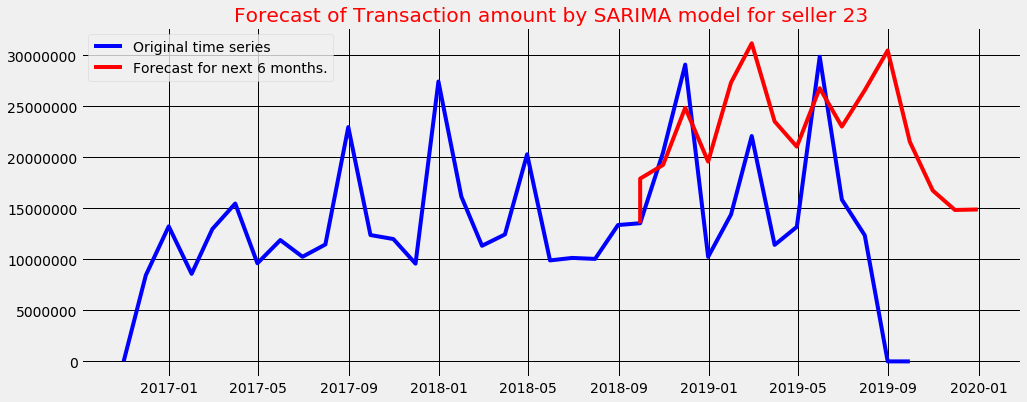

In [296]:
plt.figure(figsize=(15,6))
plt.plot(ts, color="blue", label="Original time series")
plt.plot(predict, color="red", label="Forecast for next 6 months.")
plt.title("Forecast of Transaction amount by SARIMA model for seller 23", color="red")
plt.legend(loc="best")
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)
plt.grid(True, color="black")
plt.show()